In [1]:
import lightgbm as lgb
from catboost import CatBoostRegressor
import os, glob
import json
import folium
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler



import warnings
# Filter out specific ValueWarnings from statsmodels
warnings.filterwarnings("ignore")

In [ ]:
ndays=1 #set lags time

# 1. Load data

In [2]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

## Define important columns
data_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id','prediction_unit_id']
client_cols = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_prices_cols = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh','origin_date','data_block_id']
electricity_prices_cols = ['forecast_date', 'euros_per_mwh','origin_date','data_block_id']
forecast_weather_cols = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_weather_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols = ['longitude', 'latitude', 'county']
target_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

## Importing only specified columns
df_data = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas_prices = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_prices_cols, try_parse_dates=True)
df_electricity_prices = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_prices_cols, try_parse_dates=True)
df_forecast_weather = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_weather_cols, try_parse_dates=True)
df_historical_weather = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_weather_cols, try_parse_dates=True)
df_weather_station_to_county_mapping = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_target = df_data.select(target_cols)


#### Use ERD to display data information for each table

#### Mô tả Bộ Dữ Liệu
Thử thách của bạn trong cuộc thi này là dự đoán lượng điện được sản xuất và tiêu thụ bởi các khách hàng năng lượng ở Estonia đã lắp đặt các tấm pin mặt trời. Bạn sẽ có quyền truy cập vào dữ liệu thời tiết, giá năng lượng liên quan và hồ sơ về công suất quang điện được lắp đặt.

Đây là cuộc thi dự báo sử dụng API chuỗi thời gian. Bảng xếp hạng riêng tư sẽ được xác định bằng dữ liệu thực tế thu thập sau khi kết thúc thời gian nộp bài.

💡 Lưu ý:
Tất cả các bộ dữ liệu tuân theo cùng một quy ước thời gian. Thời gian được cung cấp theo EET/EEST. Hầu hết các biến là tổng hoặc trung bình trong khoảng thời gian 1 giờ. Cột datetime (dù tên là gì) luôn cho biết thời điểm bắt đầu của khoảng thời gian 1 giờ. Tuy nhiên, đối với các bộ dữ liệu thời tiết, một số biến như nhiệt độ hoặc độ che phủ mây được cung cấp cho một thời điểm cụ thể, luôn là thời điểm kết thúc của khoảng thời gian 1 giờ.

Các tệp
train.csv

- county: Mã ID cho huyện.
- is_business: Boolean cho biết liệu người tiêu thụ có phải là doanh nghiệp hay không.
- product_type: Mã ID với ánh xạ sau đây của các mã tới các loại hợp đồng: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- target: Lượng tiêu thụ hoặc sản xuất cho phân đoạn liên quan trong giờ. Các phân đoạn được xác định bởi county, is_business, và product_type.
- is_consumption: Boolean cho biết liệu mục tiêu của hàng này là tiêu thụ hay sản xuất.
- datetime: Thời gian Estonia theo EET (UTC+2) / EEST (UTC+3). Nó mô tả thời điểm bắt đầu của khoảng thời gian 1 giờ mà mục tiêu được cung cấp.
- data_block_id: Tất cả các hàng chia sẻ cùng một data_block_id sẽ có sẵn tại cùng thời điểm dự báo. Đây là chức năng của những thông tin có sẵn khi các dự báo thực sự được thực hiện, vào lúc 11 giờ sáng mỗi ngày. Ví dụ, nếu dự báo thời tiết data_block_id cho các dự báo được thực hiện vào ngày 31 tháng 10 là 100 thì data_block_id thời tiết lịch sử cho ngày 31 tháng 10 sẽ là 101 vì dữ liệu thời tiết lịch sử chỉ thực sự có sẵn vào ngày hôm sau.
- row_id: Một mã định danh duy nhất cho hàng.
- prediction_unit_id: Một mã định danh duy nhất cho sự kết hợp giữa county, is_business, và product_type. Các đơn vị dự báo mới có thể xuất hiện hoặc biến mất trong tập kiểm tra.

gas_prices.csv

- origin_date: Ngày khi giá trước một ngày có sẵn.
- forecast_date: Ngày khi giá dự báo có liên quan.
- [lowest/highest]_price_per_mwh: Giá thấp nhất/cao nhất của khí đốt tự nhiên trên thị trường trước một ngày vào ngày giao dịch đó, tính bằng Euro mỗi megawatt giờ tương đương.
- data_block_id

client.csv

- product_type
- county: Mã ID cho huyện. Xem county_id_to_name_map.json để ánh xạ mã ID tới tên huyện.
- eic_count: Số điểm tiêu thụ tổng hợp (EICs - Mã định danh Châu Âu).
- installed_capacity: Công suất tấm pin mặt trời quang điện được lắp đặt tính bằng kilowatt.
- is_business: Boolean cho biết liệu người tiêu thụ có phải là doanh nghiệp hay không.
- date
- data_block_id

electricity_prices.csv

- origin_date
- forecast_date: Đại diện cho thời điểm bắt đầu của khoảng thời gian 1 giờ khi giá có hiệu lực.
- euros_per_mwh: Giá điện trên các thị trường trước một ngày tính bằng Euro mỗi megawatt giờ.
- data_block_id

forecast_weather.csv

Dự báo thời tiết có sẵn vào thời điểm dự báo. Nguồn từ Trung tâm Dự báo Thời tiết Tầm trung Châu Âu.

- [latitude/longitude]: Tọa độ của dự báo thời tiết.
- origin_datetime: Dấu thời gian của khi dự báo được tạo ra.
- hours_ahead: Số giờ giữa thời điểm tạo dự báo và thời điểm dự báo thời tiết. Mỗi dự báo bao gồm tổng cộng 48 giờ.
- temperature: Nhiệt độ không khí ở 2 mét trên mặt đất tính bằng độ C. Được ước tính cho thời điểm kết thúc của khoảng thời gian 1 giờ.
- dewpoint: Nhiệt độ điểm sương ở 2 mét trên mặt đất tính bằng độ C. Được ước tính cho thời điểm kết thúc của khoảng thời gian 1 giờ.
- cloudcover_[low/mid/high/total]: Tỷ lệ phần trăm của bầu trời được che phủ bởi mây ở các dải độ cao sau: 0-2 km, 2-6 km, 6+ km, và tổng cộng. Được ước tính cho thời điểm kết thúc của khoảng thời gian 1 giờ.
- 10_metre_[u/v]_wind_component: Thành phần [hướng đông/hướng bắc] của tốc độ gió đo ở 10 mét trên bề mặt tính bằng mét trên giây. Được ước tính cho thời điểm kết thúc của khoảng thời gian 1 giờ.
- data_block_id
- forecast_datetime: Dấu thời gian của thời tiết dự báo. Được tạo từ origin_datetime cộng với hours_ahead. Điều này đại diện cho thời điểm bắt đầu của khoảng thời gian 1 giờ mà dữ liệu thời tiết được dự báo.
- direct_solar_radiation: Bức xạ mặt trời trực tiếp chiếu xuống bề mặt trên một mặt phẳng vuông góc với hướng của mặt trời tích lũy trong giờ, tính bằng watt-giờ trên mét vuông.
- surface_solar_radiation_downwards: Bức xạ mặt trời, bao gồm cả trực tiếp và khuếch tán, chiếu xuống một mặt phẳng ngang trên bề mặt Trái Đất, tích lũy trong giờ, tính bằng watt-giờ trên mét vuông.
- snowfall: Lượng tuyết rơi trong giờ tính bằng mét nước tương đương.
- total_precipitation: Lượng mưa tích lũy, bao gồm cả mưa và tuyết rơi trên bề mặt Trái Đất trong giờ được mô tả, tính bằng mét.

historical_weather.csv

Dữ liệu thời tiết lịch sử.

- datetime: Đại diện cho thời điểm bắt đầu của khoảng thời gian 1 giờ mà dữ liệu thời tiết được đo.
- temperature: Được đo ở thời điểm kết thúc của khoảng thời gian 1 giờ.
- dewpoint: Được đo ở thời điểm kết thúc của khoảng thời gian 1 giờ.
- rain: Khác với các quy ước dự báo. Lượng mưa từ các hệ thống thời tiết lớn trong giờ tính bằng milimet.
- snowfall: Khác với các quy ước dự báo. Lượng tuyết rơi trong giờ tính bằng centimet.
- surface_pressure: Áp suất không khí ở mặt đất tính bằng hectopascal.
- cloudcover_[low/mid/high/total]: Khác với các quy ước dự báo. Độ che phủ mây ở các độ cao 0-3 km, 3-8 km, 8+, và tổng cộng.
- windspeed_10m: Khác với các quy ước dự báo. Tốc độ gió ở 10 mét trên mặt đất tính bằng mét trên giây.
- winddirection_10m: Khác với các quy ước dự báo. Hướng gió ở 10 mét trên mặt đất tính bằng độ.
- shortwave_radiation: Khác với các quy ước dự báo. Bức xạ toàn cầu trên mặt phẳng ngang tính bằng watt-giờ trên mét vuông.
- direct_solar_radiation
- diffuse_radiation: Khác với các quy ước dự báo. Bức xạ khuếch tán tính bằng watt-giờ trên mét vuông.
- [latitude/longitude]: Tọa độ của trạm thời tiết.
- data_block_id

public_timeseries_testing_util.py

Một tệp tùy chọn nhằm giúp dễ dàng hơn khi chạy các bài kiểm tra API tùy chỉnh offline. Xem docstring của script để biết chi tiết. Bạn sẽ cần chỉnh sửa tệp này trước khi sử dụng.

example_test_files/

Dữ liệu nhằm minh họa cách API hoạt động. Bao gồm các tệp và cột tương tự được cung cấp bởi API. Ba data_block_id đầu tiên là sự lặp lại của ba data_block_id cuối cùng trong tập huấn luyện.

example_test_files/sample_submission.csv

Một mẫu nộp hợp lệ, được cung cấp bởi API. Xem notebook này để biết một ví dụ rất đơn giản về cách sử dụng mẫu nộp.

example_test_files/revealed_targets.csv

Các giá trị mục tiêu thực tế từ ngày trước thời gian dự báo. Điều này tương đương với độ trễ hai ngày so với thời gian dự báo trong test.csv.

enefit/

Các tệp cho phép API hoạt động. Dự kiến API sẽ cung cấp tất cả các hàng trong vòng dưới 15 phút và chỉ sử dụng ít hơn 0,5

 GB bộ nhớ. Phiên bản API mà bạn có thể tải xuống cung cấp dữ liệu từ example_test_files/. Bạn phải đưa ra dự báo cho những ngày đó để tiến hành API nhưng những dự báo đó sẽ không được chấm điểm. Dự kiến có khoảng ba tháng dữ liệu được cung cấp ban đầu và tối đa mười tháng dữ liệu vào cuối kỳ dự báo.

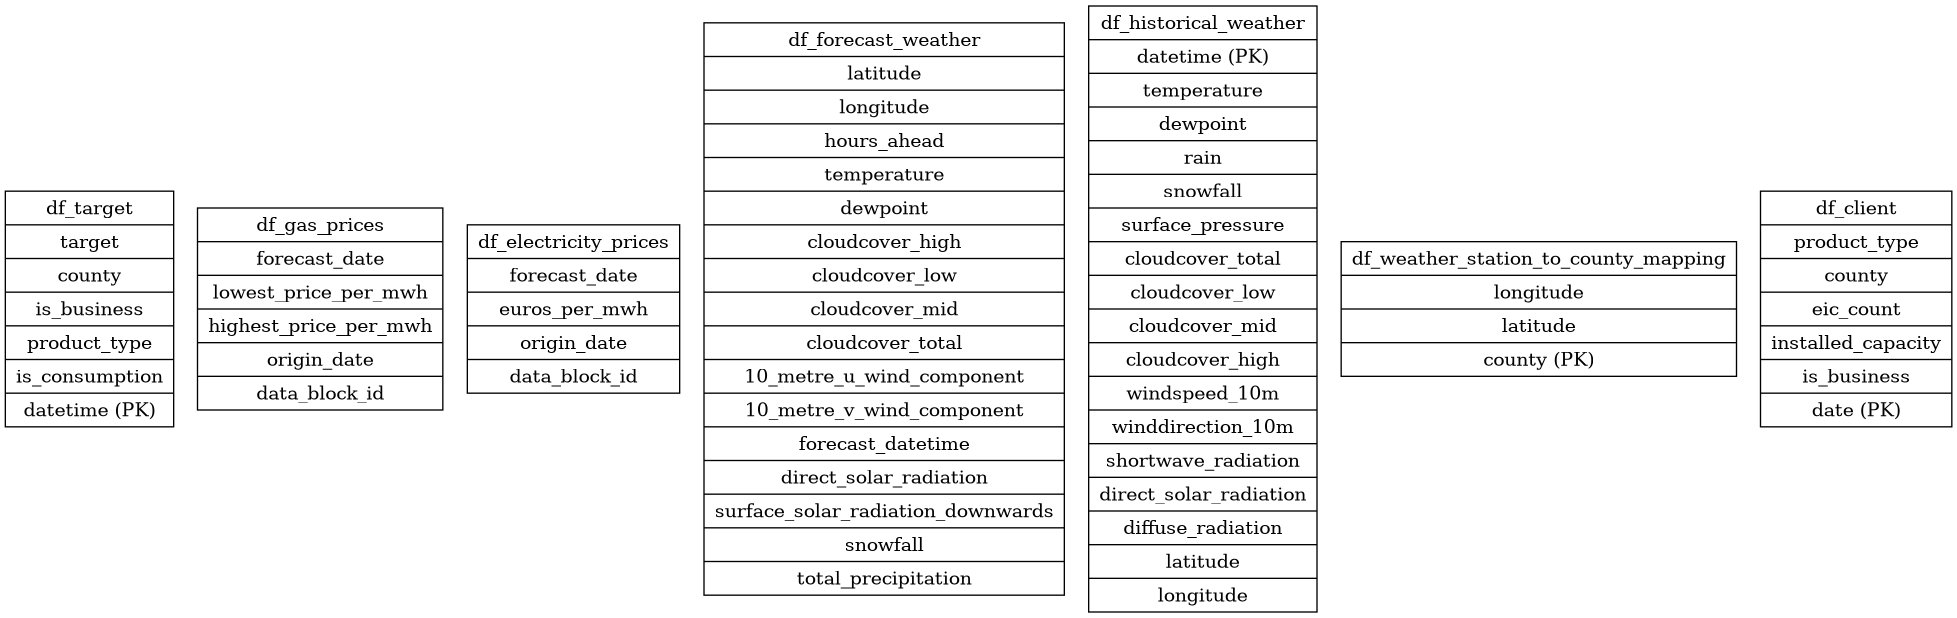

In [3]:
from graphviz import Digraph
from IPython.display import Image
import os

# Create Digraph object
dot = Digraph(comment='ERD')

# Define tables and columns along with primary and foreign keys
tables = {
    'df_target': {
        'columns': df_target.columns,
        'primary_key': 'datetime',
        'foreign_keys': {}  # Add foreign_keys if any
    },
    'df_gas_prices': {
        'columns': df_gas_prices.columns,
        'primary_key': 'forecast_date ',
        'foreign_keys': {}  # Add foreign_keys if any
    },
    'df_electricity_prices': {
        'columns': df_electricity_prices.columns,
        'primary_key': 'forecast_date ',
        'foreign_keys': {}  # Add foreign_keys if any
    },
    'df_forecast_weather': {
        'columns': df_forecast_weather.columns,
        'primary_key': 'datetime',
        'foreign_keys': {}  # Add foreign_keys if any
    },
    'df_historical_weather': {
        'columns': df_historical_weather.columns,
        'primary_key': 'datetime',
        'foreign_keys': {}  # Add foreign_keys if any
    },
    'df_weather_station_to_county_mapping': {
        'columns': df_weather_station_to_county_mapping.columns,
        'primary_key': 'county',  # Assuming station_id is the primary key
        'foreign_keys': {}  # Add foreign_keys if any
    },
    'df_client': {
        'columns': df_client.columns,
        'primary_key': 'date',  # Assuming client_id is the primary key
        'foreign_keys': {}  # Add foreign_keys if any
    }
}

# Add tables to the graph
for table, details in tables.items():
    columns = details['columns']
    primary_key = details['primary_key']
    foreign_keys = details['foreign_keys']
    
    # Create labels for columns
    column_labels = []
    for column in columns:
        if column == primary_key:
            column_labels.append(f'<{column}> {column} (PK)')
        elif column in foreign_keys:
            column_labels.append(f'<{column}> {column} (FK)')
        else:
            column_labels.append(f'<{column}> {column}')
    
    # Add table to the graph
    label = f'{{{table} | {"|".join(column_labels)}}}'
    dot.node(table, label=label, shape='record')

# Add foreign key relationships to the graph
for table, details in tables.items():
    foreign_keys = details['foreign_keys']
    for fk, ref_table in foreign_keys.items():
        dot.edge(f'{table}:{fk}', f'{ref_table}:{fk}')

# Render and save the graph as a PNG file
output_path = 'ERD'
dot.render(output_path, format='png')

# Display the image
display_image_path = output_path + '.png'
if os.path.exists(display_image_path):
    display(Image(display_image_path))
else:
    print("Error: The image file was not created.")


### a. Descriptive Statistic

In [4]:
print(f"Data is followed from '{min(df_target['datetime'])}' to '{max(df_target['datetime'])}'")

Data is followed from '2021-09-01 00:00:00' to '2023-05-31 23:00:00'


In [5]:
print(f"Data size: {len(df_data )}")

display(df_data.head())

Data size: 2018352


county,is_business,product_type,target,is_consumption,datetime,row_id,prediction_unit_id
i64,i64,i64,f64,i64,datetime[μs],i64,i64
0,0,1,0.713,0,2021-09-01 00:00:00,0,0
0,0,1,96.59,1,2021-09-01 00:00:00,1,0
0,0,2,0.0,0,2021-09-01 00:00:00,2,1
0,0,2,17.314,1,2021-09-01 00:00:00,3,1
0,0,3,2.904,0,2021-09-01 00:00:00,4,2


In [6]:
 df_data.to_pandas().isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
row_id                  0
prediction_unit_id      0
dtype: int64

In [7]:
df_data.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[us]
 6   row_id              int64         
 7   prediction_unit_id  int64         
dtypes: datetime64[us](1), float64(1), int64(6)
memory usage: 123.2 MB


In [8]:
print(f"Gas size: {len(df_gas_prices )}")

display(df_gas_prices.head())

Gas size: 637


forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
date,f64,f64,date,i64
2021-09-01,45.23,46.32,2021-08-31,1
2021-09-02,45.62,46.29,2021-09-01,2
2021-09-03,45.85,46.4,2021-09-02,3
2021-09-04,46.3,46.8,2021-09-03,4
2021-09-05,46.3,46.58,2021-09-04,5


In [9]:
df_gas_prices.to_pandas().isnull().sum()

forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64

In [10]:
df_gas_prices.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ms]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    datetime64[ms]
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ms](2), float64(2), int64(1)
memory usage: 25.0 KB


In [11]:

print(f"Electric size: {len(df_electricity_prices )}")

display(df_electricity_prices.head())

Electric size: 15286


forecast_date,euros_per_mwh,origin_date,data_block_id
datetime[μs],f64,datetime[μs],i64
2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
2021-09-01 01:00:00,88.9,2021-08-31 01:00:00,1
2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [12]:
df_electricity_prices.to_pandas().isnull().sum()

forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

In [13]:
print(f"Client size: {len(df_client )}")

display(df_client.head())

Client size: 41919


product_type,county,eic_count,installed_capacity,is_business,date
i64,i64,i64,f64,i64,date
1,0,108,952.89,0,2021-09-01
2,0,17,166.4,0,2021-09-01
3,0,688,7207.88,0,2021-09-01
0,0,5,400.0,1,2021-09-01
1,0,43,1411.0,1,2021-09-01


In [14]:
df_client.to_pandas().isnull().sum()

product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
dtype: int64

In [15]:
print(f"forecast size: {len(df_forecast_weather )}")

display(df_forecast_weather.head())

forecast size: 3424512


latitude,longitude,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],f64,f64,f64,f64
57.6,21.7,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
57.6,22.2,1,13.003931,10.689844,0.886322,0.004456,0.0,0.886658,0.206347,-5.355405,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
57.6,22.7,1,14.206567,11.671777,0.729034,0.005615,0.0,0.730499,1.451587,-7.417905,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
57.6,23.2,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
57.6,23.7,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.17659,1.268481,-8.975766,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [16]:
df_forecast_weather.to_pandas().isnull().sum()

latitude                             0
longitude                            0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64

In [17]:
np.unique(df_forecast_weather.to_pandas().hours_ahead)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [18]:
print(f"histirical size: {len(df_historical_weather )}")

display(df_historical_weather.head())

histirical size: 1710802


datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude
datetime[μs],f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,i64,f64,f64,f64,f64,f64
2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7
2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2
2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7
2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2
2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7


In [19]:
df_historical_weather.to_pandas().isnull().sum()

datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
dtype: int64

In [20]:
print(f"Weather station size: {len(df_weather_station_to_county_mapping )}")
print(type(df_weather_station_to_county_mapping))

df_weather_station_to_county_mapping = df_weather_station_to_county_mapping.drop_nulls()
display(df_weather_station_to_county_mapping)

Weather station size: 112
<class 'polars.dataframe.frame.DataFrame'>


longitude,latitude,county
f64,f64,i64
22.2,58.2,10
22.2,58.5,10
22.7,58.5,10
22.7,58.8,1
23.2,58.5,10
…,…,…
27.2,59.1,2
27.2,59.4,2
27.7,57.9,15


In [21]:
print(f"Weather station size: {len(df_weather_station_to_county_mapping )}")

display(df_weather_station_to_county_mapping.head())

Weather station size: 49


longitude,latitude,county
f64,f64,i64
22.2,58.2,10
22.2,58.5,10
22.7,58.5,10
22.7,58.8,1
23.2,58.5,10


In [22]:
df_weather_station_to_county_mapping.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  49 non-null     float64
 1   latitude   49 non-null     float64
 2   county     49 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 1.3 KB


In [23]:
print(f"Weather station size: {len(df_target )}")

display(df_target.head())

Weather station size: 2018352


target,county,is_business,product_type,is_consumption,datetime
f64,i64,i64,i64,i64,datetime[μs]
0.713,0,0,1,0,2021-09-01 00:00:00
96.59,0,0,1,1,2021-09-01 00:00:00
0.0,0,0,2,0,2021-09-01 00:00:00
17.314,0,0,2,1,2021-09-01 00:00:00
2.904,0,0,3,0,2021-09-01 00:00:00


In [24]:
df_target.to_pandas().isnull().sum()

target            528
county              0
is_business         0
product_type        0
is_consumption      0
datetime            0
dtype: int64

In [25]:
with open(os. path.join(root, f"county_id_to_name_map.json")) as fo:
    county_id_to_name = json.load(fo)
print(county_id_to_name)

{'0': 'HARJUMAA', '1': 'HIIUMAA', '2': 'IDA-VIRUMAA', '3': 'JÄRVAMAA', '4': 'JÕGEVAMAA', '5': 'LÄÄNE-VIRUMAA', '6': 'LÄÄNEMAA', '7': 'PÄRNUMAA', '8': 'PÕLVAMAA', '9': 'RAPLAMAA', '10': 'SAAREMAA', '11': 'TARTUMAA', '12': 'UNKNOWN', '13': 'VALGAMAA', '14': 'VILJANDIMAA', '15': 'VÕRUMAA'}


In [26]:
counties_locations = {
    "HARJUMAA": (59.351142, 24.725384),
    "HIIUMAA": (58.918082, 22.586403),
    "IDA-VIRUMAA": (59.228971, 27.406654),
    "JÄRVAMAA": (58.897934, 25.623048),
    "JÕGEVAMAA": (58.727941, 26.413961),
    "LÄÄNE-VIRUMAA": (59.267897, 26.363968),
    "LÄÄNEMAA": (58.975935, 23.772451),
    "PÄRNUMAA": (58.448793, 24.526469),
    "PÕLVAMAA": (58.089925, 27.101149),
    "RAPLAMAA": (58.924451, 24.619842),
    "SAAREMAA": (58.414075, 22.525137),
    "TARTUMAA": (58.394168, 26.747568),
    "VALGAMAA": (57.933466, 26.191360),
    "VILJANDIMAA": (58.316916, 25.595130),
    "VÕRUMAA": (57.765485, 27.025669)
}

In [27]:
cols_loc = ["latitude", "longitude"]
weather_locations = df_historical_weather.to_pandas().groupby(cols_loc).size().reset_index()[cols_loc]
display(weather_locations)

,latitude,longitude
0,57.6,21.7
1,57.6,22.2
2,57.6,22.7
3,57.6,23.2
4,57.6,23.7
...,...,...
107,59.7,26.2
108,59.7,26.7
109,59.7,27.2
110,59.7,27.7


# 2. Transform and pre-processing 

In [28]:
def generate_features(df_data, df_client, df_gas_prices, df_electricity_prices, df_forecast_weather, df_historical_weather, df_weather_station_to_county_mapping, df_target,ndays):
    df_data = (
        df_data.with_columns(pl.col("datetime").cast(pl.Date).alias("date"),)
    )
    
    df_gas_prices = (
        df_gas_prices.rename({"forecast_date": "date"})
    )
    
    df_electricity_prices = (
        df_electricity_prices.rename({"forecast_date": "datetime"})
    )
    
    df_weather_station_to_county_mapping = (
        df_weather_station_to_county_mapping.with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32))
    )
    
    # sum of all product_type targets related to ["datetime", "county", "is_business", "is_consumption"]
    df_target_all_type_sum = (
        df_target.group_by(["datetime", "county", "is_business", "is_consumption"]).sum().drop("product_type")
    )
    
    df_forecast_weather = (
        df_forecast_weather.rename({"forecast_datetime": "datetime"}).filter(pl.col("hours_ahead") >= 24) # we don't need forecast for today
        .with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),
            # datetime for forecast in a different timezone
            pl.col('datetime').dt.replace_time_zone(None).cast(pl.Datetime("us")),
        )
        .join(df_weather_station_to_county_mapping, how="left", on=["longitude", "latitude"]).drop("longitude", "latitude")
    )
    
    df_historical_weather = (
        df_historical_weather
        .with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_weather_station_to_county_mapping, how="left", on=["longitude", "latitude"]).drop("longitude", "latitude")
    )
    
    # creating average forecast characteristics for all weather stations
    df_forecast_weather_date = (
        df_forecast_weather.group_by("datetime").mean().drop("county")
    )
    
    # creating average forecast characteristics for weather stations related to county
    df_forecast_weather_local = (
        df_forecast_weather.filter(pl.col("county").is_not_null()).group_by("county", "datetime").mean()
    )
    
    # creating average historical characteristics for all weather stations
    df_historical_weather_date = (
        df_historical_weather.group_by("datetime").mean().drop("county")
    )
    
    # creating average historical characteristics for weather stations related to county
    df_historical_weather_local = (
        df_historical_weather.filter(pl.col("county").is_not_null()).group_by("county", "datetime").mean()
    )
    
    df_data = (
        df_data
        # pl.duration(days=1) shifts datetime to join lag features (usually we join last available values)
        .join(df_gas_prices.with_columns((pl.col("date") + pl.duration(days=ndays)).cast(pl.Date)), on="date", how="left")
        .join(df_client.with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date)), on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity_prices.with_columns(pl.col("datetime") + pl.duration(days=ndays)), on="datetime", how="left")
        
        # lag forecast_weather features (24 hours * days)
        .join(df_forecast_weather_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_weather_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_forecast_weather_date.with_columns(pl.col("datetime") + pl.duration(days=ndays)), on="datetime", how="left", suffix="_fd_7d")
        .join(df_forecast_weather_local.with_columns(pl.col("datetime") + pl.duration(days=ndays)), on=["county", "datetime"], how="left", suffix="_fl_7d")

        # lag historical_weather features (24 hours * days)
#         .join(df_historical_weather_date.with_columns(pl.col("datetime") + pl.duration(days=2)), on="datetime", how="left", suffix="_hd_2d")
#         .join(df_historical_weather_local.with_columns(pl.col("datetime") + pl.duration(days=2)), on=["county", "datetime"], how="left", suffix="_hl_2d")
        .join(df_historical_weather_date.with_columns(pl.col("datetime") + pl.duration(days=ndays)), on="datetime", how="left", suffix="_hd_7d")
        .join(df_historical_weather_local.with_columns(pl.col("datetime") + pl.duration(days=ndays)), on=["county", "datetime"], how="left", suffix="_hl_7d")
        
        # lag target features (24 hours * days)
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": f"target_{ndays}"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")        
#         .join(df_target_all_type_sum.with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": "target_1"}), on=["county", "is_business", "is_consumption", "datetime"], suffix="_all_type_sum", how="left")
#         .join(df_target_all_type_sum.with_columns(pl.col("datetime") + pl.duration(days=3)).rename({"target": "target_2"}), on=["county", "is_business", "is_consumption", "datetime"], suffix="_all_type_sum", how="left")
#         .join(df_target_all_type_sum.with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"target": "target_6"}), on=["county", "is_business", "is_consumption", "datetime"], suffix="_all_type_sum", how="left")
#         .join(df_target_all_type_sum.with_columns(pl.col("datetime") + pl.duration(days=14)).rename({"target": "target_7"}), on=["county", "is_business", "is_consumption", "datetime"], suffix="_all_type_sum", how="left")
        
        
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("segment"),
        )
        # cyclical features encoding https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
        .with_columns(
            (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        
        .drop("datetime", "hour", "dayofyear")
    )
    
    return df_data

In [29]:
## Function defined for merging dataframes with the row_id as unique identifier
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "segment"]
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
#     df["target_mean"] = df[[f"target_{i}" for i in range(1, 7)]].mean(1)
#     df["target_std"] = df[[f"target_{i}" for i in range(1, 7)]].std(1)
#     df["target_ratio"] = df["target_6"] / (df["target_7"] + 1e-3)
    
    return df

In [30]:
df_data

county,is_business,product_type,target,is_consumption,datetime,row_id,prediction_unit_id
i64,i64,i64,f64,i64,datetime[μs],i64,i64
0,0,1,0.713,0,2021-09-01 00:00:00,0,0
0,0,1,96.59,1,2021-09-01 00:00:00,1,0
0,0,2,0.0,0,2021-09-01 00:00:00,2,1
0,0,2,17.314,1,2021-09-01 00:00:00,3,1
0,0,3,2.904,0,2021-09-01 00:00:00,4,2
…,…,…,…,…,…,…,…
15,1,0,197.233,1,2023-05-31 23:00:00,2018347,64
15,1,1,0.0,0,2023-05-31 23:00:00,2018348,59
15,1,1,28.404,1,2023-05-31 23:00:00,2018349,59


## Applying Preprocessing

1. **Splitting Data into Features and Target**
   - `df_data` is updated to exclude the 'target' column.
   - `y` is created to contain only the 'target' column from `df_data`.

2. **Generating Additional Features**
   - The `generate_features` function is used to enrich `df_data` with new features created from related datasets like client, gas prices, electricity prices, forecast and historical weather data, and weather station mappings.

3. **Transforming Data for Pandas DataFrame**
   - The `to_pandas` function is applied to transform the enriched data into a pandas DataFrame, integrating the target values and creating additional engineered features such as 'target_mean', 'target_std', and 'target_ratio'.

4. **Cleaning Data**
   - Rows with null values in the 'target' column are removed to ensure data quality.
   - The dataset is filtered to include only records from the year 2022 and beyond.

The processed dataset, `df_train_features`, is now optimized and ready for use in machine learning tasks, free from null target values and focused on recent data.


In [31]:
df_data, y = df_data.drop("target"), df_data.select("target")

county_id_to_name = {
    0: 'HARJUMAA', 1: 'HIIUMAA', 2: 'IDA-VIRUMAA', 3: 'JÄRVAMAA', 4: 'JÕGEVAMAA', 
    5: 'LÄÄNE-VIRUMAA', 6: 'LÄNEMAA', 7: 'PÄRNUMAA', 8: 'PÕLVAMAA', 9: 'RAPLAMAA', 
    10: 'SAAREMAA', 11: 'TARTUMAA', 12: 'UNKNOWN', 13: 'VALGAMAA', 14: 'VILJANDIMAA', 15: 'VÕRUMAA'
}

# Chuyển cột 'county' thành kiểu chuỗi
# df_train_features['county'] = df_train_features['county'].astype(str)

# Tạo cột mới 'county_name' và ánh xạ giá trị của cột 'county' tới tên quận tương ứng

df_train_features = generate_features(df_data, df_client, df_gas_prices, df_electricity_prices, df_forecast_weather, df_historical_weather, df_weather_station_to_county_mapping, df_target, ndays=ndays)

df_train_features = to_pandas(df_train_features, y)
# a little proportion of target values are null
df_train_features = df_train_features[df_train_features['target'].notnull()]
# df_train_features['country'] = df_train_features['county'].map(county_id_to_name)


# filter old data
# df_train_features = df_train_features[df_train_features.year >= 2022]

df_train_features.head()

,county,is_business,product_type,is_consumption,prediction_unit_id,date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,...,day,weekday,month,year,segment,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),target
row_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_1_0,-0.866025,-0.5,0.0,1.0,0.713
1,0,0,1,1,0,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_1_1,-0.866025,-0.5,0.0,1.0,96.590
2,0,0,2,0,1,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_2_0,-0.866025,-0.5,0.0,1.0,0.000
3,0,0,2,1,1,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_2_1,-0.866025,-0.5,0.0,1.0,17.314
4,0,0,3,0,2,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_3_0,-0.866025,-0.5,0.0,1.0,2.904


In [32]:
df_train_features

,county,is_business,product_type,is_consumption,prediction_unit_id,date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,...,day,weekday,month,year,segment,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),target
row_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_1_0,-0.866025,-0.500000,0.000000,1.000000,0.713
1,0,0,1,1,0,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_1_1,-0.866025,-0.500000,0.000000,1.000000,96.590
2,0,0,2,0,1,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_2_0,-0.866025,-0.500000,0.000000,1.000000,0.000
3,0,0,2,1,1,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_2_1,-0.866025,-0.500000,0.000000,1.000000,17.314
4,0,0,3,0,2,2021-09-01,NaN,NaN,NaT,NaN,...,1,3,9,2021,0_0_3_0,-0.866025,-0.500000,0.000000,1.000000,2.904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,1,64,2023-05-31,29.0,34.0,2023-05-29,637.0,...,31,3,5,2023,15_1_0_1,0.522133,-0.852864,-0.258819,0.965926,197.233
2018348,15,1,1,0,59,2023-05-31,29.0,34.0,2023-05-29,637.0,...,31,3,5,2023,15_1_1_0,0.522133,-0.852864,-0.258819,0.965926,0.000
2018349,15,1,1,1,59,2023-05-31,29.0,34.0,2023-05-29,637.0,...,31,3,5,2023,15_1_1_1,0.522133,-0.852864,-0.258819,0.965926,28.404


In [33]:
df_train_features['date'].dt.year

row_id
0          2021
1          2021
2          2021
3          2021
4          2021
           ... 
2018347    2023
2018348    2023
2018349    2023
2018350    2023
2018351    2023
Name: date, Length: 2017824, dtype: int32

In [34]:
df_train_features=df_train_features[df_train_features['date'].dt.year>=2022]

# df_train_features.reset_index(drop=True)
# df_train_features.drop('row_id')

df_train_features

,county,is_business,product_type,is_consumption,prediction_unit_id,date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,...,day,weekday,month,year,segment,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),target
row_id,,,,,,,,,,,,,,,,,,,,,
366048,0,0,1,0,0,2022-01-01,80.0,94.0,2021-12-30,122.0,...,1,6,1,2022,0_0_1_0,0.017166,0.999853,0.000000,1.000000,0.000
366049,0,0,1,1,0,2022-01-01,80.0,94.0,2021-12-30,122.0,...,1,6,1,2022,0_0_1_1,0.017166,0.999853,0.000000,1.000000,442.226
366050,0,0,2,0,1,2022-01-01,80.0,94.0,2021-12-30,122.0,...,1,6,1,2022,0_0_2_0,0.017166,0.999853,0.000000,1.000000,0.000
366051,0,0,2,1,1,2022-01-01,80.0,94.0,2021-12-30,122.0,...,1,6,1,2022,0_0_2_1,0.017166,0.999853,0.000000,1.000000,44.899
366052,0,0,3,0,2,2022-01-01,80.0,94.0,2021-12-30,122.0,...,1,6,1,2022,0_0_3_0,0.017166,0.999853,0.000000,1.000000,0.015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,1,64,2023-05-31,29.0,34.0,2023-05-29,637.0,...,31,3,5,2023,15_1_0_1,0.522133,-0.852864,-0.258819,0.965926,197.233
2018348,15,1,1,0,59,2023-05-31,29.0,34.0,2023-05-29,637.0,...,31,3,5,2023,15_1_1_0,0.522133,-0.852864,-0.258819,0.965926,0.000
2018349,15,1,1,1,59,2023-05-31,29.0,34.0,2023-05-29,637.0,...,31,3,5,2023,15_1_1_1,0.522133,-0.852864,-0.258819,0.965926,28.404


In [35]:
df_train_features.to_csv(f'train_lag{ndays}.csv')